In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import os
from pathlib import Path

### Data exploration

In [2]:
data = []

for file in Path("data").glob("*.mat"):
    try:
        data.append(loadmat(file))
    except Exception as e:
        print(f"Error loading {file}: {e}")

data_1 = data[0]

In [3]:
data_1.keys()

dict_keys(['__header__', '__version__', '__globals__', 'amplitudes1', 'distances1', 'cloud1'])

In [4]:
type(data_1)

dict

In [5]:
A = data_1['amplitudes1']
distance = data_1['distances1']
PC = data_1['cloud1']

In [6]:
distance

array([[0.        , 0.        , 0.        , ..., 2.08750653, 9.91966915,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 2.21158051, 0.        ,
        0.        ],
       ...,
       [0.        , 0.81849653, 0.8396064 , ..., 0.86473584, 0.88194507,
        0.        ],
       [0.        , 0.87757653, 0.8493191 , ..., 0.84469038, 0.85190231,
        0.        ],
       [0.        , 0.92695111, 0.        , ..., 0.88022852, 0.84321123,
        0.        ]], shape=(424, 512))

In [7]:
print(A.shape, distance.shape, A.dtype, distance.dtype)
print(np.nanmin(distance), np.nanmax(distance))

(424, 512) (424, 512) uint16 float64
0.0 10.372331619262695


(np.float64(-0.5), np.float64(511.5), np.float64(423.5), np.float64(-0.5))

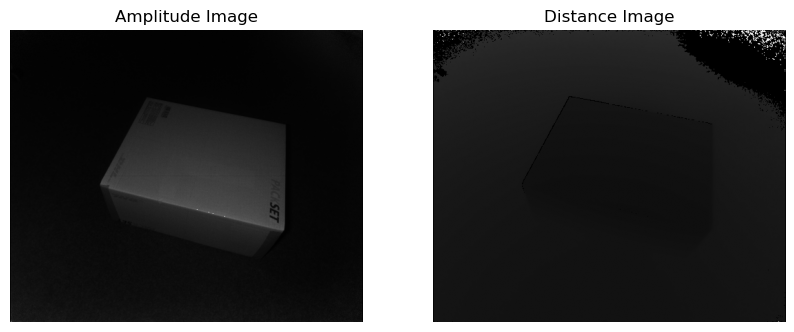

In [8]:
fig, ax = plt.subplots(1,2, figsize=(10,5)) 
ax[0].imshow(A, cmap='gray') 
ax[0].set_title('Amplitude Image') 
ax[0].axis('off') 
ax[1].imshow(distance, cmap='gray') 
ax[1].set_title('Distance Image') 
ax[1].axis('off')

The box is visible since its a solid surface and reflecting light well.

Distance image looks almost entirely the same color. Can't really understand the distance that well

In [9]:
print(f"Amplitude range: {A.min()} to {A.max()}")
print(f"Distance range: {distance.min()} to {distance.max()}")

Amplitude range: 0 to 65535
Distance range: 0.0 to 10.372331619262695


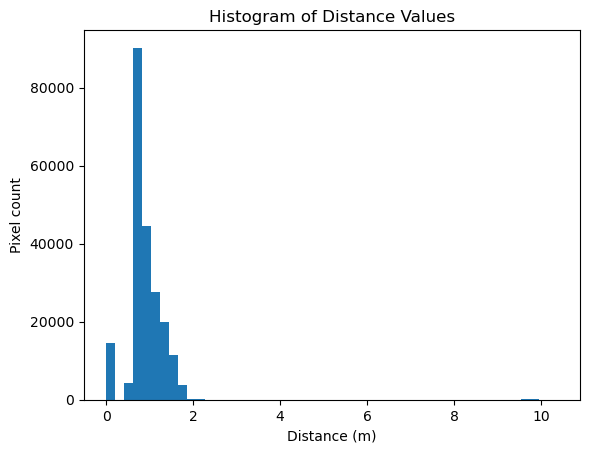

In [10]:
# checking where most pixels lie in distance image
plt.hist(distance.ravel(), bins = 50, range=(distance.min(), distance.max()))
plt.title('Histogram of Distance Values')
plt.xlabel('Distance (m)')
plt.ylabel('Pixel count')
plt.show()


So most depth values are between .15 to 2. Values around zero are not included as the object can't be 0 m away. So it is probably a failed reading

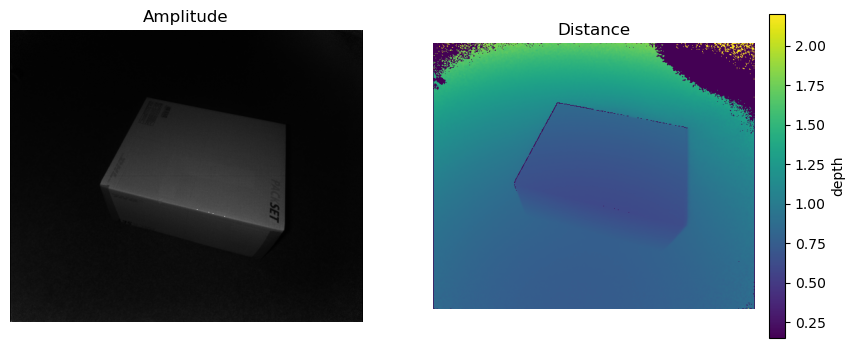

In [11]:
fig, ax = plt.subplots(1,2, figsize=(10,5))

ax[0].imshow(A, cmap='gray')
ax[0].set_title('Amplitude') 
ax[0].axis('off')

im = ax[1].imshow(distance, cmap='viridis', vmin=0.15, vmax=2.2)
ax[1].set_title('Distance') 
ax[1].axis('off')
fig.colorbar(im, ax=ax[1], fraction=0.046, pad=0.04, label='depth')


Strong border along the edges which drops in distance. So this might actually be an artifact due to weak signals

### Point cloud plot

In [12]:
PC

array([[[-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        ...,
        [ 1.13569915, -0.88586158,  1.51099968],
        [ 0.        ,  0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ]],

       [[-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        ...,
        [ 0.        , -0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ]],

       [[-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        [-0.        , -0.        ,  0.        ],
        ...,
        [ 1.20425951, -0.9299584 ,  1.60499978],
        [ 0.        , -0.        ,  0.        ],
        [ 0.        , -0.        ,  0.        ]],

       ...,

       [[-0.        ,  0.        ,  0.        ],
        [-0

In [13]:
# extract pixel value at each space
X = PC[:,:, 0].ravel()
Y = PC[:,:, 1].ravel()
Z = PC[:,:, 2].ravel()

In [14]:
X.shape, Y.shape, Z.shape

((217088,), (217088,), (217088,))

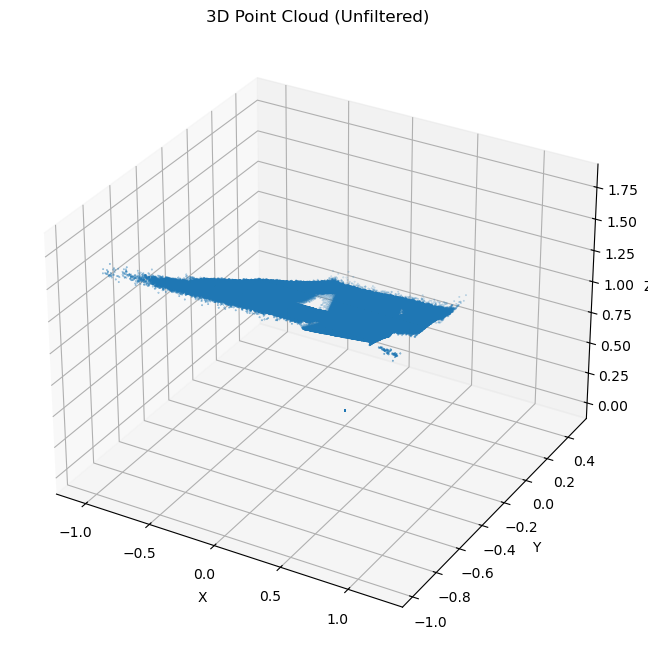

In [15]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X, Y, Z, s=0.1)

ax.set_title('3D Point Cloud (Unfiltered)')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()


The current point cloud contains a lot of redundant points (background, outliers) which we can clean up with thresholding the amplitude and distance as we are only interested in the point cloud for the box.

### Morphological operations to remove noise

We want sharper edges and less speckle noise. So first we test out mean and median filters to see how they effect the A and distance images

In [16]:
distance.shape

(424, 512)

In [17]:
from scipy.ndimage import median_filter, uniform_filter

D_mean3 = uniform_filter(distance, size=3)
D_mean5 = uniform_filter(distance, size=5)
D_median3 = median_filter(distance, size=3)   

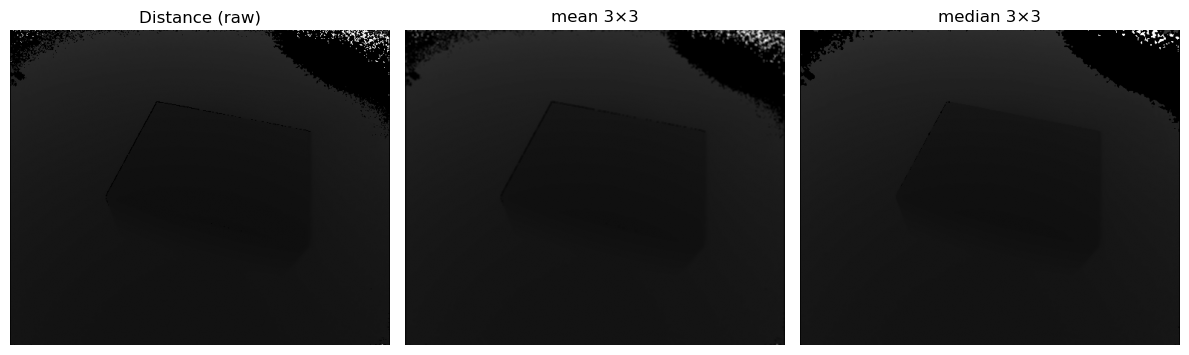

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4))

im0 = ax[0].imshow(distance, cmap='grey')
ax[0].set_title("Distance (raw)")
ax[0].axis('off')

ax[1].imshow(D_mean3,  cmap='grey')
ax[1].set_title("mean 3×3")
ax[1].axis('off')

ax[2].imshow(D_median3, cmap='grey')
ax[2].set_title("median 3×3")
ax[2].axis('off')

plt.tight_layout()
plt.show()

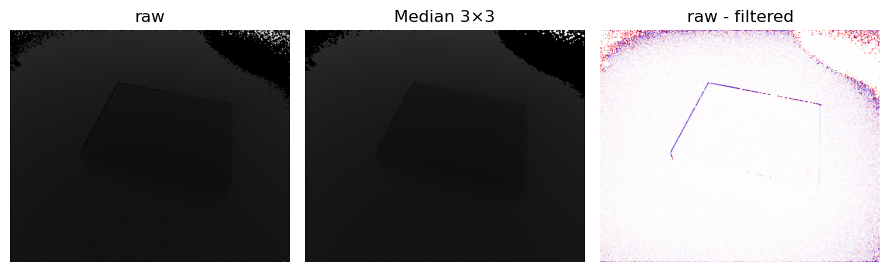

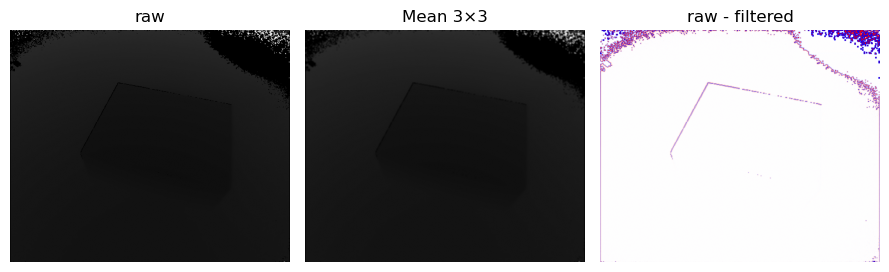

In [ ]:
def show_diff(title, raw, filt):
    """shows what the filter changed."""
    diff = raw - filt
    m = np.nanpercentile(np.abs(diff), 99) 
    plt.figure(figsize=(9,3))
    plt.subplot(1,3,1); plt.imshow(raw,  cmap='gray');      plt.title('raw');  plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(filt, cmap='gray');      plt.title(title);  plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(diff, cmap='bwr', vmin=-m, vmax=m); plt.title('raw - filtered'); plt.axis('off')
    plt.tight_layout(); plt.show()

show_diff("Median 3×3", distance, D_median3)   
show_diff("Mean 3×3",   distance, D_mean3)


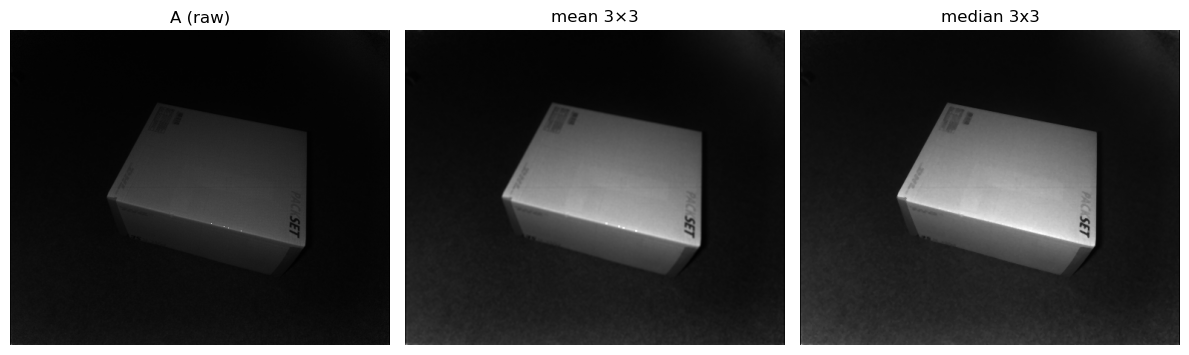

In [32]:
A_mean3 = uniform_filter(A, size=3)
A_mean5 = median_filter(A, size=3)

fig, ax = plt.subplots(1, 3, figsize=(12, 4))

im0 = ax[0].imshow(A, cmap='grey')
ax[0].set_title("A (raw)")   
ax[0].axis('off')

ax[1].imshow(A_mean3,  cmap='grey')
ax[1].set_title("mean 3×3")
ax[1].axis('off')

ax[2].imshow(A_mean5, cmap='grey')
ax[2].set_title("median 3x3")
ax[2].axis('off')

plt.tight_layout()
plt.show()

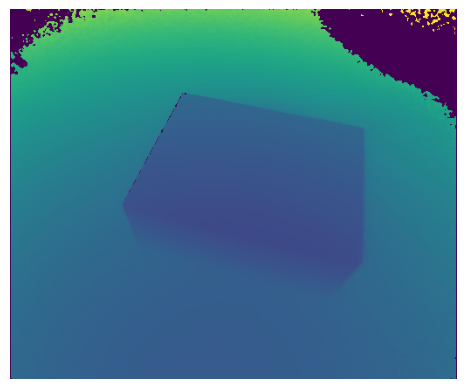

In [ ]:
vmin, vmax = 0.15, 2.2 
plt.imshow(D_median3, cmap='viridis', vmin=vmin, vmax=vmax) 
plt.axis('off') 
plt.show()


### Data clean up (Invalid/weak signals, extreme distance)

We want to keep the pixels that are 
- have some signal returned
- within a sensible distance

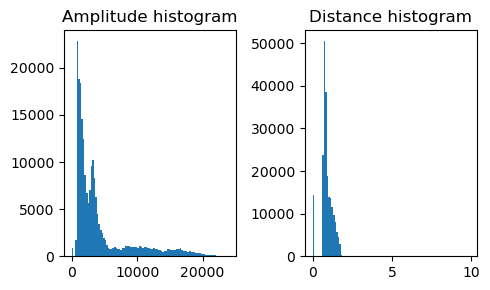

In [44]:
plt.figure(figsize=(5,3))
plt.subplot(1,2,1)
plt.hist(A_mean5.ravel(), bins=100, range=(A_mean5.min(), A_mean5.max()))
plt.title("Amplitude histogram")


plt.subplot(1,2,2)
plt.hist(D_median3.ravel(), bins=100, range=(D_median3.min(), D_median3.max()))
plt.title("Distance histogram")
plt.tight_layout()
plt.show()

Lots of low amplitudes meaning that the signals here are not reliable. 

We can also ignore the 0 values in the distance data as it suggests missing data 

In [46]:
A.shape, A.max(), A.min()

((424, 512), np.uint16(65535), np.uint16(0))

In [45]:
A_mean5.shape, A_mean5.max(), A_mean5.min()

((424, 512), np.uint16(23900), np.uint16(0))

In [47]:
np.percentile(A_mean5, (5, 99))

array([  797., 19499.])

In [22]:
np.percentile(A, (1,5,10,15,25,50,90,99))

array([  659.,   795.,   910.,  1038.,  1321.,  2515., 12059., 19534.])

In [34]:
np.percentile(D_median3, (1,5,10,15,25,50,90,99))

array([0.        , 0.        , 0.63304716, 0.66856754, 0.74426138,
       0.8290697 , 1.38200907, 1.70856619])

### Remove nan and negative data

In [48]:
A_new = A_mean5.astype(float)  # convert to float32 for processing

invalid = (
    ~np.isfinite(PC).all(axis=-1) | # remove NaN in any of the X,Y,Z coords
    (PC[:, :, 2] == 0) |    
    ~np.isfinite(D_median3) |    # remove NaN in distance
    (D_median3 <= 0) |           # remove zero or negative distances
    (A_new <= 0)                   # remove zero or negative amplitudes
)
keep = ~invalid     # pixels to keep

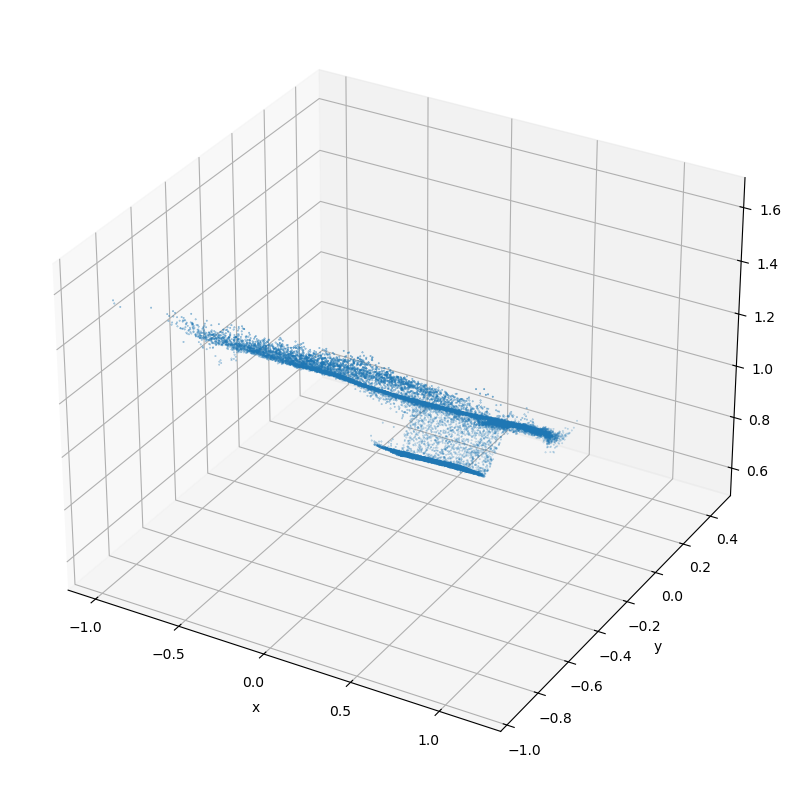

In [49]:
ii, jj = np.where(keep)
if ii.size == 0:
    print("No points to plot after filtering.")
else:
    # downsample for speed
    sel = np.random.choice(ii.size, min(20_000, ii.size), replace=False)
    ii, jj = ii[sel], jj[sel]
  
    X = PC[ii, jj, 0]
    Y = PC[ii, jj, 1]
    Z = PC[ii, jj, 2]

    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection="3d")
    ax.scatter(X, Y, Z, s=0.1)              

    ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")

    plt.tight_layout(); plt.show()


#### Remove pixels that are too far away

In [50]:
adjusted_distance = D_median3[keep]
np.percentile(adjusted_distance, (1,5,10,15,25,50,90,99))

array([0.61412084, 0.64177251, 0.67525077, 0.71690822, 0.75647819,
       0.84660536, 1.38998127, 1.69748759])

In [51]:
# cut off points for distance
near, far = np.nanpercentile(adjusted_distance, (5, 99))  
print("near, far =", near, far)

in_range = (D_median3 >= near) & (D_median3 <= far)
keep2 = keep & in_range


near, far = 0.6417725086212158 1.6974875926971436


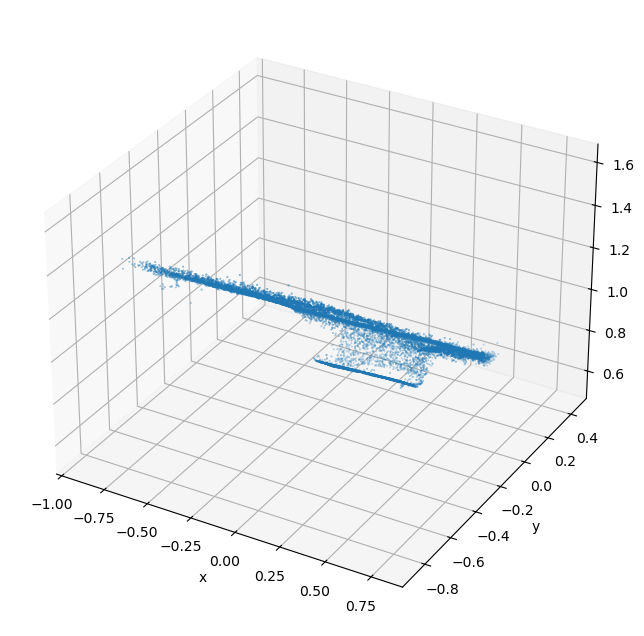

In [52]:
ii, jj = np.where(keep2)
sel = np.random.choice(ii.size, min(20_000, ii.size), replace=False)

X, Y, Z = PC[ii[sel], jj[sel], 0], PC[ii[sel], jj[sel], 1], PC[ii[sel], jj[sel], 2]
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(X, Y, Z, s=0.1)              

ax.set_xlabel("x"); ax.set_ylabel("y"); ax.set_zlabel("z")
plt.show()

### RANSAC